### Imports

In [60]:
# basic imports
import os, random
import pandas as pd
import numpy as np
import datetime as dt
import pandas_ta as ta
from pathlib import Path
import yfinance as yf
import math
from src.config import *
import inspect

# import boruta
from boruta import BorutaPy

# import minisom
from minisom import MiniSom

# warnings
import warnings
warnings.filterwarnings('ignore')

# plotting & outputs
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

# XGBoost
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_curve

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers.schedules import ExponentialDecay

#from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.optimizers.legacy import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM, BatchNormalization, Bidirectional, GRU

# kerastuner 
import keras_tuner as kt
from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband

# Set display options
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 1000)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # Machine info & package version
from watermark import watermark
%load_ext watermark
%watermark -a "Siqi He" -u -d -v -m -iv  

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Siqi He

Last updated: 2024-01-11

Python implementation: CPython
Python version       : 3.8.18
IPython version      : 8.12.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

keras_tuner: 1.3.5
matplotlib : 3.7.2
seaborn    : 0.13.0
tensorflow : 2.13.1
numpy      : 1.22.4
pandas     : 1.5.3
yfinance   : 0.2.33
pandas_ta  : 0.3.14b0



### Set up: Load datasets

In [2]:
# Data preparation: Load scaled dataframes for Train, Validation, Test
# LOAD CSV: raw Y values 
Y_train_df_raw = pd.read_csv("data/Y_train_df_raw.csv",index_col=0)
Y_dev_df_raw = pd.read_csv("data/Y_dev_df_raw.csv",index_col=0)
Y_test_df_raw = pd.read_csv("data/Y_test_df_raw.csv",index_col=0)

# LOAD CSV: Filtered - after removing high-corr
X_train_df_scaled_corr_filtered = pd.read_csv("data/X_train_df_scaled_corr_filtered.csv",index_col=0).to_numpy()
X_dev_df_scaled_corr_filtered = pd.read_csv("data/X_dev_df_scaled_corr_filtered.csv",index_col=0)
X_test_df_scaled_corr_filtered = pd.read_csv("data/X_test_df_scaled_corr_filtered.csv",index_col=0)

# LOAD CSV: Reduced dimension - after Kmeans and SOM
X_train_df_scaled_kmeans_som = pd.read_csv("data/X_train_df_scaled_kmeans_som.csv",index_col=0)
X_dev_df_scaled_kmeans_som = pd.read_csv("data/X_dev_df_scaled_kmeans_som.csv",index_col=0)
X_test_df_scaled_kmeans_som = pd.read_csv("data/X_test_df_scaled_kmeans_som.csv",index_col=0)

# LOAD CSV: Further reduced by XGBoost
X_train_df_scaled_xg = pd.read_csv("data/X_train_df_scaled_xg.csv",index_col=0)
X_dev_df_scaled_xg = pd.read_csv("data/X_dev_df_scaled_xg.csv",index_col=0)
X_test_df_scaled_xg = pd.read_csv("data/X_test_df_scaled_xg.csv",index_col=0)

# view sample feature set
X_train_df_scaled_xg

,WILLR_14,BBP_5_2.0,VCHG_2,STD_63,GAP_3,PCHG_2,CKSPl_10_3_20,STD_3,Mkt-RF,VHF_28,MACDh_12_26_9,VCHG_63,GAP_4,THERMO_20_2_0.5,PVO_12_26_9,...,PPOh_12_26_9,PVOh_12_26_9,GBPUSD=X_Close,GAP_2,SMB,VCHG_1,DMP_14,^FTSE_Close,VTXM_14,dsin,BBB_5_2.0,HML,ER_10,AD,MASSI_9_25
0,0.076734,-0.390621,-0.170862,-0.090478,-0.273369,-1.031079,1.623661,0.072627,0.486486,0.613907,1.290233,0.219413,-0.221454,0.430629,-0.479601,...,0.374750,0.140792,0.228313,-0.677519,-0.020408,-0.139776,2.283319,0.259824,-0.277996,0.433884,0.177006,0.043478,0.482508,1.509226,1.102748
1,0.059680,-0.485234,-0.415944,-0.115661,-0.728628,-0.344201,1.639169,-0.198157,-0.054054,0.713555,0.971918,-0.522727,-0.379045,0.897359,-0.624051,...,0.322398,-0.099869,0.608384,-0.179615,0.489796,-0.279575,2.001703,-0.053300,-0.330060,-0.433884,0.104483,-0.282609,-0.049717,1.512624,1.025024
2,0.092805,-0.246218,-0.609040,-0.115434,-0.283141,0.025803,1.657413,-0.598468,0.032432,0.696304,0.731593,-0.448552,-0.713536,-0.595914,-0.868236,...,0.385694,-0.447878,-0.254330,-0.437854,0.244898,-0.403336,1.838463,-0.124135,-0.473537,-0.974928,0.006146,1.847826,-0.135956,1.515244,0.912759
3,0.028021,-0.520160,-0.399661,-0.115259,0.302931,-0.098843,1.670525,-0.743685,0.129730,0.366477,0.461385,-0.427586,0.295895,-0.726579,-1.068856,...,0.239335,-0.658370,0.124259,0.603449,0.714286,0.032720,1.646422,0.421903,-0.796591,0.974928,-0.730399,0.043478,0.071471,1.503808,0.686135
4,-0.045053,-0.826751,0.806589,-0.115410,0.839802,-0.375475,1.682877,-0.679642,-0.378378,0.570205,0.178100,-0.246017,0.527492,0.020029,-1.005650,...,0.136767,-0.415475,-0.275278,1.214832,0.510204,0.952643,1.410299,0.054196,-0.641540,0.433884,-0.762788,0.695652,-0.273531,1.499302,0.440891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,0.687365,-0.081214,-0.181734,0.031710,-0.428149,-0.198224,0.852888,0.038799,0.281081,0.550486,-0.382766,0.181716,-0.936902,0.955415,-0.233002,...,-0.359198,0.308251,-0.075513,-0.570349,0.183673,-0.013083,1.163784,0.289411,-0.082615,-0.433884,-0.514799,-0.956522,-0.797456,-1.122057,0.486153
1427,-0.807432,-0.721870,0.345706,0.043626,-0.428012,-0.262307,0.852888,0.225531,-0.086486,0.515266,-0.627028,0.246060,-0.330564,0.540587,0.064174,...,-0.507885,0.722566,-0.402738,0.620943,0.061224,0.492244,0.962135,-0.194257,-0.138207,-0.974928,-0.291017,-0.260870,-0.109200,-1.173370,0.341962
1428,-0.661451,-0.562555,-0.507586,-0.219410,0.604362,-0.732682,0.852888,0.091204,0.021622,0.790326,-0.811064,-0.819929,-0.270979,-0.198148,-0.122326,...,-0.709189,0.299998,-0.274547,0.129799,0.428571,-0.774613,0.774889,0.382888,-0.101190,0.781831,-0.154240,-0.130435,0.716448,-1.193657,0.315068
1429,-0.422076,-0.098798,-0.765551,-0.230603,0.281931,0.092260,0.859820,-0.049326,0.118919,0.815707,-0.836908,0.028405,0.629279,0.693120,-0.296110,...,-0.861694,-0.018233,-0.685270,0.311243,-0.326531,-0.040872,0.601019,0.022318,0.142316,0.974928,-0.422076,-0.500000,0.211338,-1.175907,0.272505


### Set up: Class weights, time series generation, global parameters

In [65]:
# set class weights

def cwts(dfs):
    '''
    Calculates class weights based on target value counts in a numpy array or pandas dataframe of target variable Y.
    '''
    c0, c1 = np.bincount(dfs)
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    
    return {0: w0, 1: w1}

# time series generator to transform data for LSTM input

def time_series_generator(X, Y, seqlen):
    '''
    Calls the TimeSeriesGenerator module in Tensorflow.preprocessing.sequence.
    For a given pair of X, Y and lookback period
    '''
    return TimeseriesGenerator(X, Y, length=seqlen)

# turn Y raw values into direction labels

y_train = np.where(Y_train_df_raw['label']>0.001, 1, 0)
y_dev = np.where(Y_dev_df_raw['label']>0.001, 1, 0)
y_test = np.where(Y_test_df_raw['label']>0.001, 1, 0)

# create classweights

class_weight = cwts(y_train)

# create sequential data

g_train_corr_filtered = time_series_generator(X_train_df_scaled_corr_filtered, y_train, seqlen=21)
g_dev_corr_filtered = time_series_generator(X_dev_df_scaled_corr_filtered, y_dev, seqlen=21)
g_test_corr_filtered = time_series_generator(X_test_df_scaled_corr_filtered, y_test, seqlen=21)

g_train_kmeans_som = time_series_generator(X_train_df_scaled_kmeans_som, y_train, seqlen=21)
g_dev_kmeans_som = time_series_generator(X_dev_df_scaled_kmeans_som, y_dev, seqlen=21)
g_test_kmeans_som = time_series_generator(X_test_df_scaled_kmeans_som, y_test, seqlen=21)

g_train_xg = time_series_generator(X_train_df_scaled_xg, y_train, seqlen=21)
g_dev_xg = time_series_generator(X_dev_df_scaled_xg, y_dev, seqlen=21)
g_test_xg = time_series_generator(X_test_df_scaled_xg, y_test, seqlen=21)

# Visualise sequential data shape

print("Sequential data after filtering high-correlation: " )
for i in range(len(g_train_corr_filtered)):
    a, b = g_train_corr_filtered[i]
    print(a.shape, b.shape)
print()
print("Sequential data from K-means clustering and SOM selection: " )
for i in range(len(g_train_kmeans_som)):
    a, b = g_train_kmeans_som[i]
    print(a.shape, b.shape)
print()
print("Sequential data from XGBoost selection: " )
for i in range(len(g_train_xg)):
    a, b = g_train_xg[i]
    print(a.shape, b.shape)

# Create result path

results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)
    
# Other global parameters

num_features_kmeans_som = X_train_df_scaled_kmeans_som.shape[1]                       # number of features selected by K-means and SOM
num_features_corr_filtered = X_train_df_scaled_corr_filtered.shape[1]                 # number of features remaining after filtering high correlation
num_features_xg = X_train_df_scaled_xg.shape[1]                                       # number of features selectee after XGBoost

seqlen = 21     # lookback period
trials = 50     # number of trials
LR = 0.005      # Learning rate
BATCH = 64      # batch size
EPOCHS = 50     # number of epochs
PATIENCE = 10   # patience
logdir = f"./tensorboard/LSTM/initial_run/"  # tensorboard root directory

Sequential data after filtering high-correlation: 
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(128, 21, 199) (128,)
(2, 21, 199) (2,)

Sequential data from K-means clustering and SOM selection: 
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(128, 21, 96) (128,)
(2, 21, 96) (2,)

Sequential data from XGBoost selection: 
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(128, 21, 37) (128,)
(2, 21, 37) (2,)


### Bayesian Optimisation Function

In [4]:
# Declaire Bayesian Optimisation search function
def BO_search(hp_model,                  
                  data="som_kmeans",
                  class_weights=class_weight, 
                  trials=50, 
                  num_initial_points=2,
                  epochs=50,
                  patience=10, 
                  batch=64,
                  g_train=g_train_corr_filtered, 
                  g_valid=g_dev_corr_filtered
             ):

    # Specify callback functions
    datetime = dt.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    logdir = f"./tensorboard/bologs/{data}/bologs_{hp_model.__name__}_{datetime}"

    # initialize an early stopping callback to prevent the model from
    # overfitting/spending too much time training with minimal gains
    callback3 = [EarlyStopping(patience=patience, 
                               monitor='loss', 
                               mode='min', 
                               verbose=1, 
                               restore_best_weights=True), \
                               TensorBoard(log_dir=logdir)
                            ]

    botuner = BayesianOptimization(hypermodel = hp_model,
                                   objective="val_loss",
                                   max_trials=trials,
                                   num_initial_points=num_initial_points,
                                   hyperparameters=None,
                                   tune_new_entries=True,
                                   allow_new_entries=True,
                                   directory="./keras",
                                   project_name=f"botrail_{hp_model.__name__}_{datetime}", \
                                   overwrite=True
                                  )

    botuner.search(g_train, 
                   epochs=epochs, 
                   validation_data=g_valid, 
                   callbacks=callback3, 
                   class_weight = class_weight, 
                   shuffle=False
                  )
    
    # Display the best hyperparameter values for the model based on the defined objective function
    best_bohp = botuner.get_best_hyperparameters()[0]

    # Display tuning results summary
    botuner.results_summary()

    # Build best model using tuned hyperparameters
    best_search_model = botuner.hypermodel.build(best_bohp)
    best_search_model.fit(g_train,
                          epochs=epochs,
                          batch_size=batch,
                          validation_data=g_valid,
                          verbose=1,
                          callbacks=callback3,
                          class_weight=class_weights,
                          shuffle=False
                          )
    best_search_model.summary()
    best_search_model.save(f"./models/hptuning/{data}/bo_{hp_model.__name__}_{datetime}")

    return botuner, best_bohp


### Hypermodel: XG_Set Architecture 2

In [6]:
# Define function for hypermodel tuning
def hp_xg_lstm_2(hp, seqlen=seqlen, numfeat=num_features_xg):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_end1 = hp.Int('Dense_end_units1', min_value=int((1/8)*numfeat), max_value=int((1/2)*numfeat), step=2)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('lstm_units1', min_value=6, max_value=30, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate1', min_value=0, max_value=0.5, step=0.1)
    
    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'lstm_activation1', values = ['relu', 'elu'], ordered = False)

    hp_dense_end_activation1 = hp.Choice(name = 'Dense_end_activation1', values = ['relu', 'elu'], ordered = False)
    
    # Model architecture
    
    # (1) LSTM layers and dropouts
    model.add(LSTM (hp_lstm1, activation = hp_lstm_activation1, return_sequences=False, name='lstm1'))
    model.add(Dropout(hp_dropout1, name ='Dropout1'))

    # (2) Dense and output layer
    model.add(Dense(units=hp_dense_end1, activation=hp_dense_end_activation1, name='Dense_end1')) 
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model XG architecture no.1
botuner_xg_2, best_bohp_xg_2 = BO_search(hp_model=hp_xg_lstm_2, 
                                          data="xg_jan10",
                                          class_weights=class_weight, 
                                          trials=trials,
                                          num_initial_points=2,
                                          epochs=EPOCHS,
                                          patience=PATIENCE, 
                                          batch=BATCH,
                                          g_train=g_train_xg, 
                                          g_valid=g_dev_xg)

Trial 50 Complete [00h 00m 06s]
val_loss: 0.6946256160736084

Best val_loss So Far: 0.6873179078102112
Total elapsed time: 00h 05m 32s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./keras/botrail_hp_xg_lstm_2_2024_01_10-22_29_13
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 34 summary
Hyperparameters:
Dense_end_units1: 4
lstm_units1: 18
Dropout_rate1: 0.1
learning_rate: 0.007494748800250223
lstm_activation1: relu
Dense_end_activation1: relu
Score: 0.6873179078102112

Trial 17 summary
Hyperparameters:
Dense_end_units1: 6
lstm_units1: 22
Dropout_rate1: 0.1
learning_rate: 0.0009087513410666269
lstm_activation1: elu
Dense_end_activation1: relu
Score: 0.6875358819961548

Trial 11 summary
Hyperparameters:
Dense_end_units1: 6
lstm_units1: 22
Dropout_rate1: 0.1
learning_rate: 0.008570929401443564
lstm_activation1: relu
Dense_end_activation1: relu
Score: 0.6893224716186523

Trial 23 summary
Hyperparameters:
Dense_end_units1: 6
lstm_units1: 18
Drop

INFO:tensorflow:Assets written to: ./models/hptuning/xg_jan10/bo_hp_xg_lstm_2_2024_01_10-22_29_13/assets


### Hypermodel: XG_Set Architecture 4

In [7]:
# Define function for hypermodel tuning
def hp_xg_lstm_4(hp, seqlen=seqlen, numfeat=num_features_xg):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_end1 = hp.Int('Dense_end_units1', min_value=int((1/8)*numfeat), max_value=int((1/2)*numfeat), step=2)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('lstm_units1', min_value=6, max_value=30, step=4)
    hp_lstm2 = hp.Int('lstm_units2', min_value=6, max_value=30, step=4)
    hp_lstm3 = hp.Int('lstm_units3', min_value=4, max_value=30, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate2', min_value=0, max_value=0.5, step=0.1)
    
    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'lstm_activation1', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation2 = hp.Choice(name = 'lstm_activation2', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation3 = hp.Choice(name = 'lstm_activation3', values = ['relu', 'elu'], ordered = False)

    hp_dense_end_activation1 = hp.Choice(name = 'Dense_end_activation1', values = ['relu', 'elu', 'tanh'], ordered = False)
    
    # Model architecture
    
    # (1) LSTM layers and dropouts
    model.add(LSTM (hp_lstm1, activation = hp_lstm_activation1, return_sequences=True, name='lstm1'))
    model.add(Dropout(hp_dropout1, name ='Dropout1'))
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation2, return_sequences=True, name='lstm2'))  
    model.add(Dropout(hp_dropout2, name ='Dropout2'))
    model.add(LSTM (hp_lstm2, activation = hp_lstm_activation3, return_sequences=False, name='lstm3'))  

    # (2) Dense and output layer
    model.add(Dense(units=hp_dense_end1, activation=hp_dense_end_activation1, name='Dense_end1')) 
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model XG architecture no.1
botuner_xg_4, best_bohp_xg_4 = BO_search(hp_model=hp_xg_lstm_4, 
                                              data="xg_jan10",
                                              class_weights=class_weight, 
                                              trials=trials,
                                              num_initial_points=2,
                                              epochs=EPOCHS,
                                              patience=PATIENCE, 
                                              batch=BATCH,
                                              g_train=g_train_xg, 
                                              g_valid=g_dev_xg)

Trial 50 Complete [00h 00m 12s]
val_loss: 0.6979271769523621

Best val_loss So Far: 0.6876689195632935
Total elapsed time: 00h 10m 34s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./keras/botrail_hp_xg_lstm_4_2024_01_10-22_34_51
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 11 summary
Hyperparameters:
Dense_end_units1: 6
lstm_units1: 22
lstm_units2: 26
lstm_units3: 24
Dropout_rate1: 0.0
Dropout_rate2: 0.1
learning_rate: 0.0075916030548332444
lstm_activation1: elu
lstm_activation2: relu
lstm_activation3: relu
Dense_end_activation1: elu
Score: 0.6876689195632935

Trial 04 summary
Hyperparameters:
Dense_end_units1: 8
lstm_units1: 26
lstm_units2: 26
lstm_units3: 28
Dropout_rate1: 0.4
Dropout_rate2: 0.0
learning_rate: 0.0003822744975100949
lstm_activation1: relu
lstm_activation2: relu
lstm_activation3: relu
Dense_end_activation1: tanh
Score: 0.6890264749526978

Trial 28 summary
Hyperparameters:
Dense_end_units1: 8
lstm_units1: 14
lstm_units2: 30
lstm_units3: 12
Dropout_rate1: 0.2
Dropout_rate2: 0.2
learning_rate: 0.0004026644556959732
lstm_activation1: relu
lstm_activation2: elu
lstm_activation3: relu
Dense_end_a

INFO:tensorflow:Assets written to: ./models/hptuning/xg_jan10/bo_hp_xg_lstm_4_2024_01_10-22_34_51/assets


### Hypermodel: XG_Set Architecture 7

In [8]:
# Define function for hypermodel tuning
def hp_xg_lstm_7(hp, seqlen=seqlen, numfeat=num_features_xg):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_end1 = hp.Int('Dense_end_units1', min_value=int((1/8)*numfeat), max_value=int((1/2)*numfeat), step=2)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('lstm_units1', min_value=6, max_value=30, step=4)
    hp_lstm2 = hp.Int('lstm_units2', min_value=6, max_value=30, step=4)
    hp_lstm3 = hp.Int('lstm_units3', min_value=6, max_value=30, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate2', min_value=0, max_value=0.5, step=0.1)
    
    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'lstm_activation1', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation2 = hp.Choice(name = 'lstm_activation2', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation3 = hp.Choice(name = 'lstm_activation3', values = ['relu', 'elu'], ordered = False)

    hp_dense_end_activation1 = hp.Choice(name = 'Dense_end_activation1', values = ['relu', 'elu', 'tanh'], ordered = False)
    # Model architecture
    
    # (1) LSTM layers and dropouts
    model.add(LSTM (hp_lstm1, activation = hp_lstm_activation1, return_sequences=True, name='lstm1'))
    model.add(Dropout(hp_dropout1, name ='Dropout1'))
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation2, return_sequences=True, name='lstm2'))  
    model.add(Dropout(hp_dropout2, name ='Dropout2'))
    model.add(LSTM (hp_lstm2, activation = hp_lstm_activation3, return_sequences=False, name='lstm3'))  

    # (2) Dense and output layer
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model XG architecture no.7
botuner_xg_7, best_bohp_xg_7 = BO_search(hp_model=hp_xg_lstm_7, 
                                          data="xg_jan10",
                                          class_weights=class_weight, 
                                          trials=trials,
                                          num_initial_points=2,
                                          epochs=EPOCHS,
                                          patience=PATIENCE, 
                                          batch=BATCH,
                                          g_train=g_train_xg, 
                                          g_valid=g_dev_xg)

Trial 50 Complete [00h 00m 18s]
val_loss: 0.6895283460617065

Best val_loss So Far: 0.6887970566749573
Total elapsed time: 00h 12m 01s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./keras/botrail_hp_xg_lstm_7_2024_01_10-22_45_40
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 42 summary
Hyperparameters:
Dense_end_units1: 12
lstm_units1: 26
lstm_units2: 26
lstm_units3: 14
Dropout_rate1: 0.4
Dropout_rate2: 0.30000000000000004
learning_rate: 0.0014200703216337616
lstm_activation1: relu
lstm_activation2: relu
lstm_activation3: elu
Dense_end_activation1: elu
Score: 0.6887970566749573

Trial 05 summary
Hyperparameters:
Dense_end_units1: 4
lstm_units1: 18
lstm_units2: 26
lstm_units3: 18
Dropout_rate1: 0.2
Dropout_rate2: 0.4
learning_rate: 0.006081156339477851
lstm_activation1: elu
lstm_activation2: relu
lstm_activation3: relu
Dense_end_activation1: tanh
Score: 0.689055323600769

Trial 49 summary
Hyperparameters:
Dense_end_units1: 16
lstm_units1: 30
lstm_units2: 22
lstm_units3: 26
Dropout_rate1: 0.4
Dropout_rate2: 0.30000000000000004
learning_rate: 0.0003518197534412724
lstm_activation1: relu
lstm_activation2: elu
lst

INFO:tensorflow:Assets written to: ./models/hptuning/xg_jan10/bo_hp_xg_lstm_7_2024_01_10-22_45_40/assets


### Hypermodel: KS_Set Architecture 12

In [9]:
# Define function for hypermodel tuning
def hp_ks_lstm_12(hp, seqlen=seqlen, numfeat=num_features_kmeans_som):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_start1 = hp.Int('Dense_start_units1', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=8)
    hp_dense_start2 = hp.Int('Dense_start_units2', min_value=int((1/8)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    hp_dense_end1 = hp.Int('Dense_end_units1', min_value=int((1/16)*numfeat), max_value=int((1/8)*numfeat), step=4)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('LSTM_units_1', min_value=6, max_value=30, step=4)

    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'LSTM_activation1', values = ['relu', 'elu', 'tanh'], ordered = False)

    hp_dense_start_activation1 = hp.Choice(name = 'Dense_start_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_start_activation2 = hp.Choice(name = 'Dense_start_activation2', values = ['relu', 'elu'], ordered = False)

    hp_dense_end_activation1 = hp.Choice(name = 'Dense_end_activation1', values = ['relu', 'elu', 'tanh'], ordered = False)
    
    # Model architecture

    # (1) Dense layers before LSTM
    model.add(Dense(units=hp_dense_start1, activation=hp_dense_start_activation1, name='Dense_start1')) 
    model.add(Dense(units=hp_dense_start2, activation=hp_dense_start_activation2, name='Dense_start2'))
    
    # (2) LSTM layers and dropouts
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=False, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name ='Dropout1'))

    # (3) Output layer
    model.add(Dense(units=hp_dense_end1, activation=hp_dense_end_activation1, name='Dense_end1')) 
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model KS architecture no.12
botuner_ks_12, best_bohp_ks_12 = BO_search(hp_model=hp_ks_lstm_12, 
                                              data="ks_jan10",
                                              class_weights=class_weight, 
                                              trials=trials,
                                              num_initial_points=2,
                                              epochs=EPOCHS,
                                              patience=PATIENCE, 
                                              batch=BATCH,
                                              g_train=g_train_kmeans_som, 
                                              g_valid=g_dev_kmeans_som)

Trial 50 Complete [00h 00m 09s]
val_loss: 0.6921126842498779

Best val_loss So Far: 0.6882616281509399
Total elapsed time: 00h 07m 03s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./keras/botrail_hp_ks_lstm_12_2024_01_10-22_58_00
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 21 summary
Hyperparameters:
Dense_start_units1: 88
Dense_start_units2: 20
Dense_end_units1: 6
LSTM_units_1: 18
Dropout_rate: 0.0
learning_rate: 0.0010669121791749866
LSTM_activation1: relu
Dense_start_activation1: relu
Dense_start_activation2: elu
Dense_end_activation1: elu
Score: 0.6882616281509399

Trial 04 summary
Hyperparameters:
Dense_start_units1: 56
Dense_start_units2: 32
Dense_end_units1: 6
LSTM_units_1: 26
Dropout_rate: 0.1
learning_rate: 0.0005188260797000658
LSTM_activation1: relu
Dense_start_activation1: elu
Dense_start_activation2: elu
Dense_end_activation1: relu
Score: 0.6890685558319092

Trial 29 summary
Hyperparameters:
Dense_start_units1: 72
Dense_start_units2: 28
Dense_end_units1: 10
LSTM_units_1: 10
Dropout_rate: 0.4
learning_rate: 0.0002590102458181235
LSTM_activation1: relu
Dense_start_activation1: relu
Dense_start_a

INFO:tensorflow:Assets written to: ./models/hptuning/ks_jan10/bo_hp_ks_lstm_12_2024_01_10-22_58_00/assets


### Hypermodel: KS_Set Architecture 23

In [10]:
# Define function for hypermodel tuning
def hp_ks_lstm_23(hp, seqlen=seqlen, numfeat=num_features_kmeans_som):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_start1 = hp.Int('Dense_start_units1', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=8)
    hp_dense_start2 = hp.Int('Dense_start_units2', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    hp_dense_start3 = hp.Int('Dense_start_units3', min_value=int((1/8)*numfeat), max_value=int((1/4)*numfeat), step=2)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('LSTM_units1', min_value=6, max_value=30, step=4)
    hp_lstm2 = hp.Int('LSTM_units2', min_value=6, max_value=30, step=4)
    hp_lstm3 = hp.Int('LSTM_units3', min_value=6, max_value=30, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate2', min_value=0, max_value=0.5, step=0.1)
    
    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'LSTM_activation1', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation2 = hp.Choice(name = 'LSTM_activation2', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation3 = hp.Choice(name = 'LSTM_activation3', values = ['relu', 'elu', 'tanh'], ordered = False)

    hp_dense_start_activation1 = hp.Choice(name = 'Dense_start_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_start_activation2 = hp.Choice(name = 'Dense_start_activation2', values = ['relu', 'elu'], ordered = False)
    hp_dense_start_activation3 = hp.Choice(name = 'Dense_start_activation3', values = ['relu', 'elu'], ordered = False)
    
    # Model architecture

    # (1) Dense layers before LSTM
    model.add(Dense(units=hp_dense_start1, activation=hp_dense_start_activation1, name='Dense_start1')) 
    model.add(Dense(units=hp_dense_start2, activation=hp_dense_start_activation2, name='Dense_start2'))
    model.add(Dense(units=hp_dense_start3, activation=hp_dense_start_activation3, name='Dense_start3'))
    
    # (2) LSTM layers and dropouts
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=True, name='lstm1'))
    model.add(Dropout(hp_dropout1, name ='Dropout1'))
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=True, name='lstm2'))
    model.add(Dropout(hp_dropout2, name ='Dropout2'))
    model.add(LSTM (hp_lstm2, activation = hp_lstm_activation3, return_sequences=False, name='lstm3'))  
    

    # (3) Output layer
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model KS architecture no.23
botuner_ks_23, best_bohp_ks_23 = BO_search(hp_model=hp_ks_lstm_23, 
                                              data="ks_jan10",
                                              class_weights=class_weight, 
                                              trials=trials,
                                              num_initial_points=2,
                                              epochs=EPOCHS,
                                              patience=PATIENCE, 
                                              batch=BATCH,
                                              g_train=g_train_kmeans_som, 
                                              g_valid=g_dev_kmeans_som)

Trial 50 Complete [00h 00m 15s]
val_loss: 0.6906505823135376

Best val_loss So Far: 0.6885485649108887
Total elapsed time: 00h 21m 47s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./keras/botrail_hp_ks_lstm_23_2024_01_10-23_05_12
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
Dense_start_units1: 80
Dense_start_units2: 44
Dense_start_units3: 24
LSTM_units1: 18
LSTM_units2: 18
LSTM_units3: 10
Dropout_rate1: 0.2
Dropout_rate2: 0.1
learning_rate: 0.00016258647379571554
LSTM_activation1: relu
LSTM_activation2: elu
LSTM_activation3: elu
Dense_start_activation1: elu
Dense_start_activation2: relu
Dense_start_activation3: relu
Score: 0.6885485649108887

Trial 09 summary
Hyperparameters:
Dense_start_units1: 96
Dense_start_units2: 44
Dense_start_units3: 24
LSTM_units1: 26
LSTM_units2: 14
LSTM_units3: 22
Dropout_rate1: 0.2
Dropout_rate2: 0.2
learning_rate: 0.00014849702078788762
LSTM_activation1: elu
LSTM_activation2: elu
LSTM_activation3: elu
Dense_start_activation1: relu
Dense_start_activation2: relu
Dense_start_activation3: relu
Score: 0.6893181800842285

Trial 40 summary
Hyperparameters:
D

INFO:tensorflow:Assets written to: ./models/hptuning/ks_jan10/bo_hp_ks_lstm_23_2024_01_10-23_05_12/assets


### Hypermodel: KS_Set Architecture 26

In [11]:
# Define function for hypermodel tuning
def hp_ks_lstm_26(hp, seqlen=seqlen, numfeat=num_features_kmeans_som):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_start1 = hp.Int('Dense_start_units1', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=8)
    hp_dense_start2 = hp.Int('Dense_start_units2', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)

    hp_dense_end1 = hp.Int('Dense_end_units1', min_value=int((1/8)*numfeat), max_value=int((1/4)*numfeat), step=2)
    hp_dense_end2 = hp.Int('Dense_end_units2', min_value=int((1/16)*numfeat), max_value=int((1/8)*numfeat), step=1)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('LSTM_units1', min_value=6, max_value=30, step=4)
    hp_lstm2 = hp.Int('LSTM_units2', min_value=6, max_value=30, step=4)
    hp_lstm3 = hp.Int('LSTM_units3', min_value=6, max_value=30, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate2', min_value=0, max_value=0.5, step=0.1)
    
    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'LSTM_activation1', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation2 = hp.Choice(name = 'LSTM_activation2', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation3 = hp.Choice(name = 'LSTM_activation3', values = ['relu', 'elu', 'tanh'], ordered = False)

    hp_dense_start_activation1 = hp.Choice(name = 'Dense_start_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_start_activation2 = hp.Choice(name = 'Dense_start_activation2', values = ['relu', 'elu'], ordered = False)

    hp_dense_end_activation1 = hp.Choice(name = 'Dense_end_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_end_activation2 = hp.Choice(name = 'Dense_end_activation2', values = ['relu', 'elu'], ordered = False)
    
    # Model architecture

    # (1) Dense layers before LSTM
    model.add(Dense(units=hp_dense_start1, activation=hp_dense_start_activation1, name='Dense_start1')) 
    model.add(Dense(units=hp_dense_start2, activation=hp_dense_start_activation2, name='Dense_start2'))
    
    # (2) LSTM layers and dropouts
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=True, name='lstm1'))
    model.add(Dropout(hp_dropout1, name ='Dropout1'))
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=True, name='lstm2'))
    model.add(Dropout(hp_dropout2, name ='Dropout2'))
    model.add(LSTM (hp_lstm2, activation = hp_lstm_activation3, return_sequences=False, name='lstm3'))  
    

    # (3) Output layer
    model.add(Dense(units=hp_dense_end1, activation=hp_dense_end_activation1, name='Dense_end1')) 
    model.add(Dense(units=hp_dense_end2, activation=hp_dense_end_activation2, name='Dense_end2')) 
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model KS architecture no.23
botuner_ks_26, best_bohp_ks_26 = BO_search(hp_model=hp_ks_lstm_26, 
                                              data="ks_jan10",
                                              class_weights=class_weight, 
                                              trials=trials,
                                              num_initial_points=2,
                                              epochs=EPOCHS,
                                              patience=PATIENCE, 
                                              batch=BATCH,
                                              g_train=g_train_kmeans_som, 
                                              g_valid=g_dev_kmeans_som)

Trial 50 Complete [00h 00m 15s]
val_loss: 0.6891137957572937

Best val_loss So Far: 0.6882128119468689
Total elapsed time: 01h 13m 00s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./keras/botrail_hp_ks_lstm_26_2024_01_10-23_27_15
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 20 summary
Hyperparameters:
Dense_start_units1: 80
Dense_start_units2: 48
Dense_end_units1: 18
Dense_end_units2: 10
LSTM_units1: 22
LSTM_units2: 10
LSTM_units3: 22
Dropout_rate1: 0.4
Dropout_rate2: 0.4
learning_rate: 0.004646431921174847
LSTM_activation1: relu
LSTM_activation2: elu
LSTM_activation3: tanh
Dense_start_activation1: elu
Dense_start_activation2: elu
Dense_end_activation1: elu
Dense_end_activation2: relu
Score: 0.6882128119468689

Trial 45 summary
Hyperparameters:
Dense_start_units1: 48
Dense_start_units2: 28
Dense_end_units1: 24
Dense_end_units2: 6
LSTM_units1: 22
LSTM_units2: 14
LSTM_units3: 22
Dropout_rate1: 0.4
Dropout_rate2: 0.2
learning_rate: 0.009391708764502196
LSTM_activation1: relu
LSTM_activation2: relu
LSTM_activation3: tanh
Dense_start_activation1: relu
Dense_start_activation2: elu
Dense_end_activation1: relu
Dens

INFO:tensorflow:Assets written to: ./models/hptuning/ks_jan10/bo_hp_ks_lstm_26_2024_01_10-23_27_15/assets


### Hypermodel: HC_Set Architecture 12

In [12]:
# Define function for hypermodel tuning
def hp_hc_lstm_12(hp, seqlen=seqlen, numfeat=num_features_corr_filtered):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_start1 = hp.Int('Dense_start_units1', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=8)
    hp_dense_start2 = hp.Int('Dense_start_units2', min_value=int((1/8)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    hp_dense_end1 = hp.Int('Dense_end_units1', min_value=int((1/16)*numfeat), max_value=int((1/8)*numfeat), step=4)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('LSTM_units_1', min_value=6, max_value=30, step=4)

    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'LSTM_activation1', values = ['relu', 'elu', 'tanh'], ordered = False)

    hp_dense_start_activation1 = hp.Choice(name = 'Dense_start_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_start_activation2 = hp.Choice(name = 'Dense_start_activation2', values = ['relu', 'elu'], ordered = False)

    hp_dense_end_activation1 = hp.Choice(name = 'Dense_end_activation1', values = ['relu', 'elu'], ordered = False)
    
    # Model architecture

    # (1) Dense layers before LSTM
    model.add(Dense(units=hp_dense_start1, activation=hp_dense_start_activation1, name='Dense_start1')) 
    model.add(Dense(units=hp_dense_start2, activation=hp_dense_start_activation2, name='Dense_start2'))
    
    # (2) LSTM layers and dropouts
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=False, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name ='Dropout1'))

    # (3) Output layer
    model.add(Dense(units=hp_dense_end1, activation=hp_dense_end_activation1, name='Dense_end1')) 
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model HC architecture no.12
botuner_hc_12, best_bohp_hc_12 = BO_search(hp_model=hp_hc_lstm_12, 
                                              data="hc_jan10",
                                              class_weights=class_weight, 
                                              trials=trials,
                                              num_initial_points=2,
                                              epochs=EPOCHS,
                                              patience=PATIENCE, 
                                              batch=BATCH,
                                              g_train=g_train_corr_filtered, 
                                              g_valid=g_dev_corr_filtered)

Trial 50 Complete [00h 00m 12s]
val_loss: 0.6776136159896851

Best val_loss So Far: 0.6699366569519043
Total elapsed time: 00h 46m 34s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./keras/botrail_hp_hc_lstm_12_2024_01_11-00_40_29
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 42 summary
Hyperparameters:
Dense_start_units1: 107
Dense_start_units2: 84
Dense_end_units1: 12
LSTM_units_1: 10
Dropout_rate: 0.1
learning_rate: 0.002635725165470654
LSTM_activation1: relu
Dense_start_activation1: elu
Dense_start_activation2: elu
Dense_end_activation1: elu
Score: 0.6699366569519043

Trial 18 summary
Hyperparameters:
Dense_start_units1: 155
Dense_start_units2: 80
Dense_end_units1: 12
LSTM_units_1: 10
Dropout_rate: 0.30000000000000004
learning_rate: 0.0023401928446399422
LSTM_activation1: relu
Dense_start_activation1: relu
Dense_start_activation2: elu
Dense_end_activation1: relu
Score: 0.6701833009719849

Trial 02 summary
Hyperparameters:
Dense_start_units1: 99
Dense_start_units2: 64
Dense_end_units1: 16
LSTM_units_1: 10
Dropout_rate: 0.4
learning_rate: 0.0004545450254658464
LSTM_activation1: relu
Dense_start_activation1:

INFO:tensorflow:Assets written to: ./models/hptuning/hc_jan10/bo_hp_hc_lstm_12_2024_01_11-00_40_29/assets


### Hypermodel: HC_Set Architecture 14

In [13]:
# Define function for hypermodel tuning
def hp_hc_lstm_14(hp, seqlen=seqlen, numfeat=num_features_corr_filtered):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_start1 = hp.Int('Dense_start_units1', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=8)
    hp_dense_start2 = hp.Int('Dense_start_units2', min_value=int((1/8)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    hp_dense_end1 = hp.Int('Dense_end_units1', min_value=int((1/16)*numfeat), max_value=int((1/8)*numfeat), step=2)
    hp_dense_end2 = hp.Int('Dense_end_units2', min_value=int((1/32)*numfeat), max_value=int((1/16)*numfeat), step=1)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('LSTM_units_1', min_value=6, max_value=30, step=4)

    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'LSTM_activation1', values = ['relu', 'elu', 'tanh'], ordered = False)

    hp_dense_start_activation1 = hp.Choice(name = 'Dense_start_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_start_activation2 = hp.Choice(name = 'Dense_start_activation2', values = ['relu', 'elu'], ordered = False)

    hp_dense_end_activation1 = hp.Choice(name = 'Dense_end_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_end_activation2 = hp.Choice(name = 'Dense_end_activation2', values = ['relu', 'elu'], ordered = False)
    
    # Model architecture

    # (1) Dense layers before LSTM
    model.add(Dense(units=hp_dense_start1, activation=hp_dense_start_activation1, name='Dense_start1')) 
    model.add(Dense(units=hp_dense_start2, activation=hp_dense_start_activation2, name='Dense_start2'))
    
    # (2) LSTM layers and dropouts
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=False, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name ='Dropout1'))

    # (3) Output layer
    model.add(Dense(units=hp_dense_end1, activation=hp_dense_end_activation1, name='Dense_end1')) 
    model.add(Dense(units=hp_dense_end2, activation=hp_dense_end_activation2, name='Dense_end2')) 
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model HC architecture no.14
botuner_hc_14, best_bohp_hc_14 = BO_search(hp_model=hp_hc_lstm_14, 
                                              data="hc_jan10",
                                              class_weights=class_weight, 
                                              trials=trials,
                                              num_initial_points=2,
                                              epochs=EPOCHS,
                                              patience=PATIENCE, 
                                              batch=BATCH,
                                              g_train=g_train_corr_filtered, 
                                              g_valid=g_dev_corr_filtered)

Trial 50 Complete [00h 00m 11s]
val_loss: 0.689334511756897

Best val_loss So Far: 0.6634334325790405
Total elapsed time: 00h 14m 23s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./keras/botrail_hp_hc_lstm_14_2024_01_11-01_27_12
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 31 summary
Hyperparameters:
Dense_start_units1: 115
Dense_start_units2: 68
Dense_end_units1: 18
Dense_end_units2: 8
LSTM_units_1: 22
Dropout_rate: 0.4
learning_rate: 0.00038620810704716126
LSTM_activation1: elu
Dense_start_activation1: elu
Dense_start_activation2: elu
Dense_end_activation1: relu
Dense_end_activation2: elu
Score: 0.6634334325790405

Trial 24 summary
Hyperparameters:
Dense_start_units1: 187
Dense_start_units2: 28
Dense_end_units1: 22
Dense_end_units2: 9
LSTM_units_1: 26
Dropout_rate: 0.30000000000000004
learning_rate: 0.0002846704882184436
LSTM_activation1: tanh
Dense_start_activation1: relu
Dense_start_activation2: elu
Dense_end_activation1: elu
Dense_end_activation2: relu
Score: 0.6711959838867188

Trial 47 summary
Hyperparameters:
Dense_start_units1: 155
Dense_start_units2: 52
Dense_end_units1: 22
Dense_end_units2: 6
LS

INFO:tensorflow:Assets written to: ./models/hptuning/hc_jan10/bo_hp_hc_lstm_14_2024_01_11-01_27_12/assets


### Hypermodel: HC_Set Architecture 21

In [14]:
# Define function for hypermodel tuning
def hp_hc_lstm_21(hp, seqlen=seqlen, numfeat=num_features_corr_filtered):

    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()

    # Tune the number of units in dense layers
    hp_dense_start1 = hp.Int('Dense_start_units1', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=8)
    hp_dense_start2 = hp.Int('Dense_start_units2', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    hp_dense_start3 = hp.Int('Dense_start_units2', min_value=int((1/8)*numfeat), max_value=int((1/4)*numfeat), step=2)

    hp_dense_end1 = hp.Int('Dense_end_units1', min_value=int((1/8)*numfeat), max_value=int((1/4)*numfeat), step=2)
    hp_dense_end2 = hp.Int('Dense_end_units2', min_value=int((1/16)*numfeat), max_value=int((1/8)*numfeat), step=1)
    
    # Tune the number of units in the LSTM layers
    hp_lstm1 = hp.Int('LSTM_units1', min_value=6, max_value=30, step=4)
    hp_lstm2 = hp.Int('LSTM_units2', min_value=6, max_value=30, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate1', min_value=0, max_value=0.5, step=0.1)
    
    # Tune the learning rate for the optimiser
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_lstm_activation1 = hp.Choice(name = 'LSTM_activation1', values = ['relu', 'elu'], ordered = False)
    hp_lstm_activation2 = hp.Choice(name = 'LSTM_activation2', values = ['relu', 'elu'], ordered = False)

    hp_dense_start_activation1 = hp.Choice(name = 'Dense_start_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_start_activation2 = hp.Choice(name = 'Dense_start_activation2', values = ['relu', 'elu'], ordered = False)
    hp_dense_start_activation3 = hp.Choice(name = 'Dense_start_activation3', values = ['relu', 'elu'], ordered = False)

    hp_dense_end_activation1 = hp.Choice(name = 'Dense_end_activation1', values = ['relu', 'elu'], ordered = False)
    hp_dense_end_activation2 = hp.Choice(name = 'Dense_end_activation2', values = ['relu', 'elu'], ordered = False)
    
    # Model architecture

    # (1) Dense layers before LSTM
    model.add(Dense(units=hp_dense_start1, activation=hp_dense_start_activation1, name='Dense_start1')) 
    model.add(Dense(units=hp_dense_start2, activation=hp_dense_start_activation2, name='Dense_start2'))
    model.add(Dense(units=hp_dense_start3, activation=hp_dense_start_activation3, name='Dense_start3'))
    
    # (2) LSTM layers and dropouts
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=True, name='lstm1'))
    model.add(Dropout(hp_dropout1, name ='Dropout1'))
    model.add(LSTM(hp_lstm1, activation = hp_lstm_activation1, return_sequences=False, name='lstm2'))

    # (3) Output layer
    model.add(Dense(units=hp_dense_end1, activation=hp_dense_end_activation1, name='Dense_end1')) 
    model.add(Dense(units=hp_dense_end2, activation=hp_dense_end_activation2, name='Dense_end2')) 
    model.add(Dense(units=1, activation='sigmoid', name='Output'))  

    # Optimiser
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate, epsilon=1e-08)

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    
    return model

# Tuning hyperparameters of model HC architecture no.21
botuner_hc_21, best_bohp_hc_21 = BO_search(hp_model=hp_hc_lstm_21, 
                                              data="hc_jan10",
                                              class_weights=class_weight, 
                                              trials=trials,
                                              num_initial_points=2,
                                              epochs=EPOCHS,
                                              patience=PATIENCE, 
                                              batch=BATCH,
                                              g_train=g_train_corr_filtered, 
                                              g_valid=g_dev_corr_filtered)

Trial 50 Complete [00h 00m 18s]
val_loss: 0.6886017918586731

Best val_loss So Far: 0.6671620011329651
Total elapsed time: 00h 11m 17s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ./keras/botrail_hp_hc_lstm_21_2024_01_11-01_41_47
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 11 summary
Hyperparameters:
Dense_start_units1: 195
Dense_start_units2: 81
Dense_end_units1: 26
Dense_end_units2: 13
LSTM_units1: 6
LSTM_units2: 14
Dropout_rate1: 0.2
learning_rate: 0.0016224619152272561
LSTM_activation1: relu
LSTM_activation2: elu
Dense_start_activation1: relu
Dense_start_activation2: elu
Dense_start_activation3: relu
Dense_end_activation1: relu
Dense_end_activation2: elu
Score: 0.6671620011329651

Trial 27 summary
Hyperparameters:
Dense_start_units1: 99
Dense_start_units2: 65
Dense_end_units1: 34
Dense_end_units2: 14
LSTM_units1: 26
LSTM_units2: 14
Dropout_rate1: 0.4
learning_rate: 0.0024315731418435983
LSTM_activation1: relu
LSTM_activation2: elu
Dense_start_activation1: elu
Dense_start_activation2: elu
Dense_start_activation3: relu
Dense_end_activation1: relu
Dense_end_activation2: relu
Score: 0.6672563552856445

Tri

INFO:tensorflow:Assets written to: ./models/hptuning/hc_jan10/bo_hp_hc_lstm_21_2024_01_11-01_41_47/assets


### View tensorboards

In [80]:
# HC_set models
!tensorboard --logdir ./tensorboard/bologs/hc_jan10


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [82]:
# XG_set models
!tensorboard --logdir ./tensorboard/bologs/xg_jan10


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [81]:
# KS_set models
!tensorboard --logdir ./tensorboard/bologs/ks_jan10


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Load saved best models in directory

In [76]:
# Create function to get list of model sub directories (names) for all feature sets
def load_models(main_dir):
    '''
    Loads saved best models in BO tuner from directory, returns in a list. 
    '''
    
    # Make a list of model sub directories from main directory
    model_list = os.listdir(main_dir)
    
    # Create empty list of loaded models
    loaded_models = []
    
    # Load each model in main directory with sub directory value
    for sub_dir in model_list:
        model = load_model(f"{main_dir}/{sub_dir}")

        # append loaded model to list
        loaded_models.append(model)
        
    return loaded_models

# Load best models saved for all three candidate feature sets
best_xg_models = load_models(main_dir = "./models/hptuning/xg_jan10")
best_ks_models = load_models(main_dir = "./models/hptuning/ks_jan10")
best_hc_models = load_models(main_dir = "./models/hptuning/hc_jan10")


### Get model results

In [63]:
def display_model_results(model, g_test, true_labels, threshold=0.001):
    
    '''
    Function for plotting the confusion matrix and ROC curve for a tuner-identified best model. 
    '''
    # Display model summary
    model.summary()
    
    # Slice true labels to match the shape of predicted labels
    sliced_true_labels = true_labels[(-1)*model.predict(g_test).shape[0]:]
    # Generate predicted labels based on given threshold
    predicted_labels = np.where(model.predict(g_test, verbose=False) > threshold, 1, 0)
    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix(sliced_true_labels, predicted_labels),
                                       display_labels=[0, 1])
    cm_display.plot(cmap='Blues', values_format='.5g')
    plt.title('Confusion Matrix')
    plt.show()

    # Create dataFrame to store predicted probabilities
    prob_df = pd.DataFrame(model.predict(g_test), columns=['Prob_1'])
    prob_df['Prob_0'] = 1 - prob_df['Prob_1']
    prob_array = prob_df.loc[:,['Prob_0', 'Prob_1']].to_numpy()

    # Plot ROC curve
    prob_array = model.predict(g_test)
    fpr, tpr, _ = roc_curve(sliced_true_labels, prob_array)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print classification report
    print("Model classification Report:")
    print(classification_report(sliced_true_labels, predicted_labels, zero_division=0))
    
    return

### Display model results for all best models tuned

XG set models:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, None, 26)          6656      
                                                                 
 Dropout1 (Dropout)          (None, None, 26)          0         
                                                                 
 lstm2 (LSTM)                (None, None, 26)          5512      
                                                                 
 Dropout2 (Dropout)          (None, None, 26)          0         
                                                                 
 lstm3 (LSTM)                (None, 26)                5512      
                                                                 
 Output (Dense)              (None, 1)                 27        
                                                                 
Total params: 17707 (69.17 KB)
Trainable 

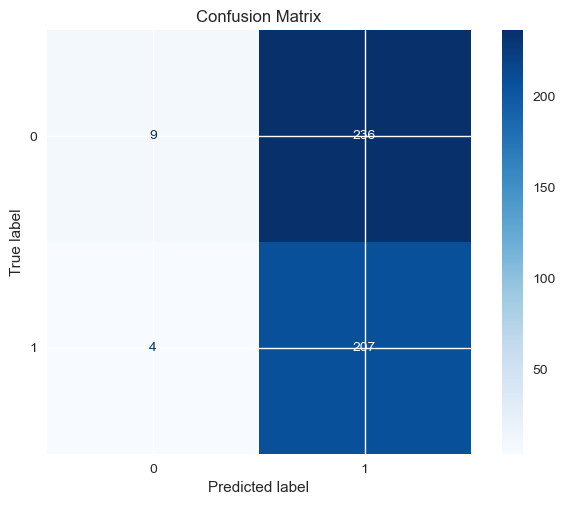

4/4 [==============================] - 0s 5ms/step


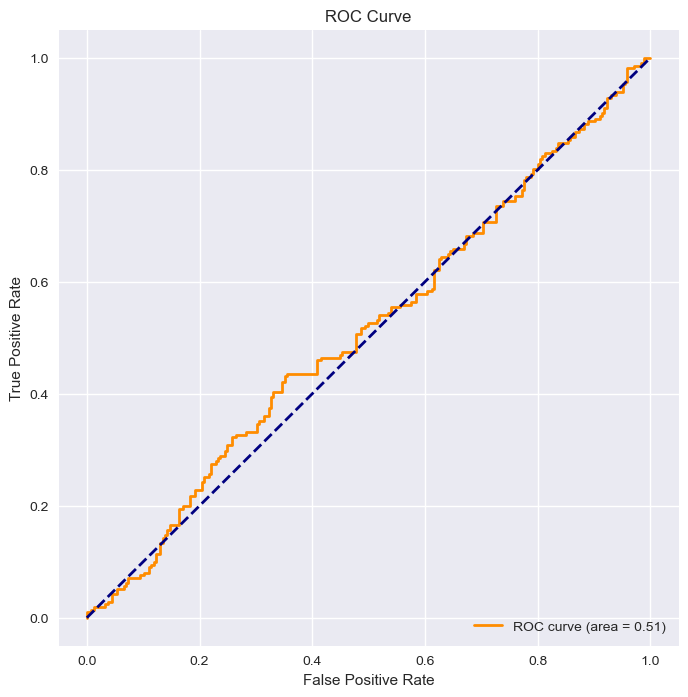

Model classification Report:
              precision    recall  f1-score   support

           0       0.69      0.04      0.07       245
           1       0.47      0.98      0.63       211

    accuracy                           0.47       456
   macro avg       0.58      0.51      0.35       456
weighted avg       0.59      0.47      0.33       456

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, None, 22)          5280      
                                                                 
 Dropout1 (Dropout)          (None, None, 22)          0         
                                                                 
 lstm2 (LSTM)                (None, None, 22)          3960      
                                                                 
 Dropout2 (Dropout)          (None, None, 22)          0         
                              

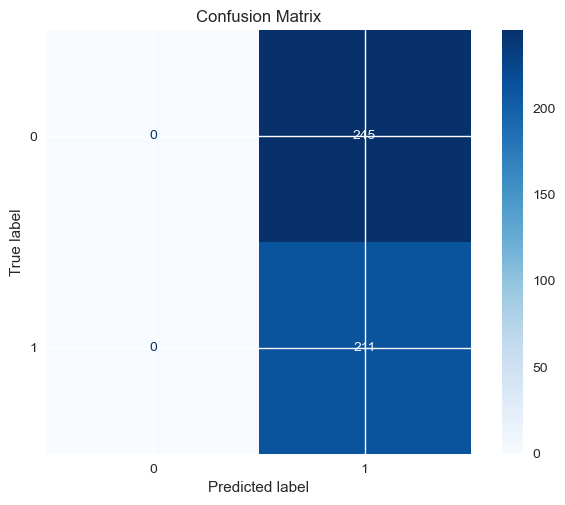

4/4 [==============================] - 0s 5ms/step


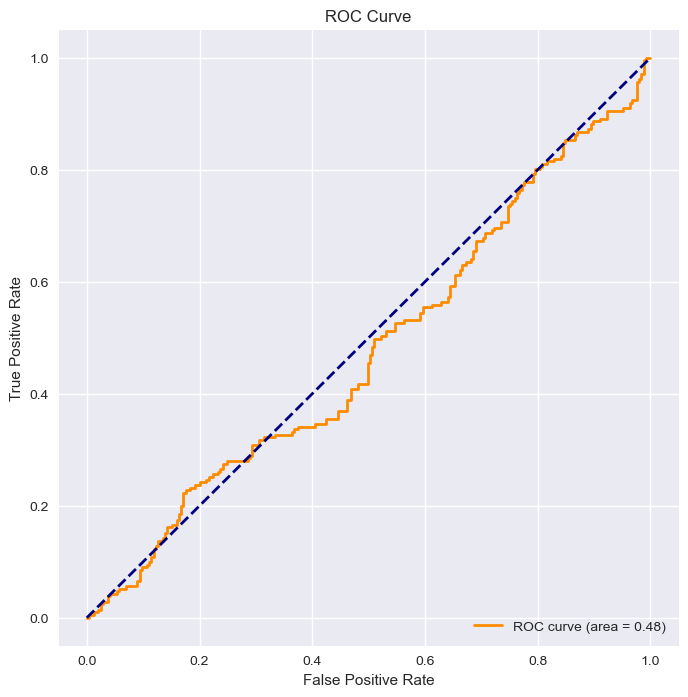

Model classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       245
           1       0.46      1.00      0.63       211

    accuracy                           0.46       456
   macro avg       0.23      0.50      0.32       456
weighted avg       0.21      0.46      0.29       456

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 18)                4032      
                                                                 
 Dropout1 (Dropout)          (None, 18)                0         
                                                                 
 Dense_end1 (Dense)          (None, 4)                 76        
                                                                 
 Output (Dense)              (None, 1)                 5         
                              

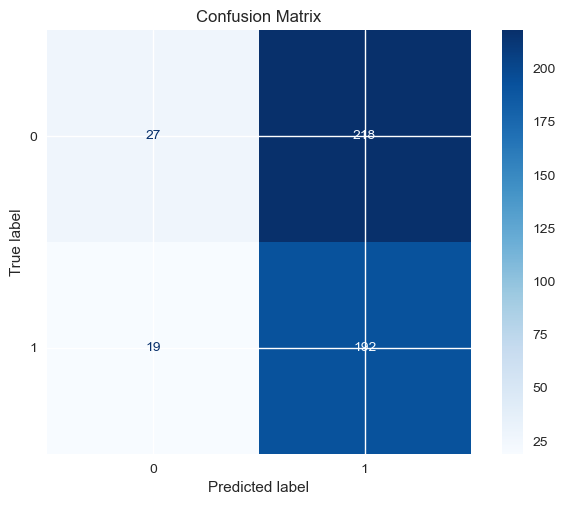

4/4 [==============================] - 0s 3ms/step


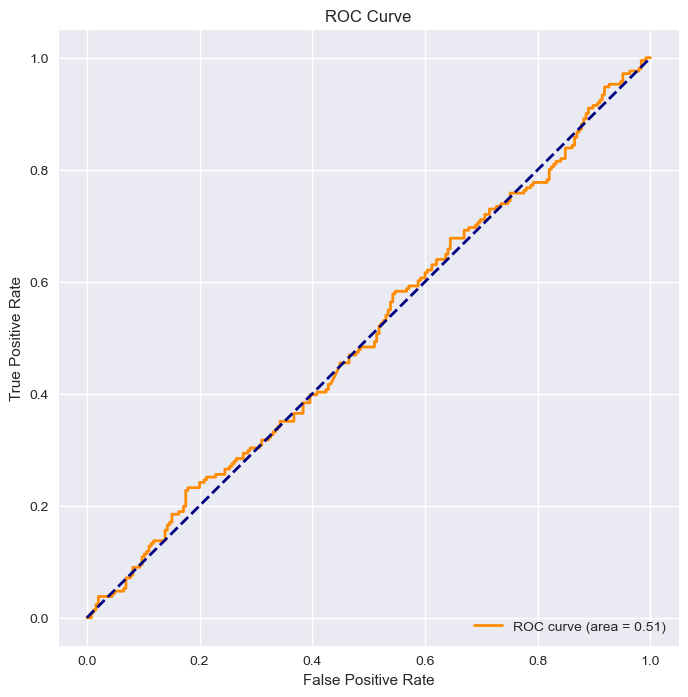

Model classification Report:
              precision    recall  f1-score   support

           0       0.59      0.11      0.19       245
           1       0.47      0.91      0.62       211

    accuracy                           0.48       456
   macro avg       0.53      0.51      0.40       456
weighted avg       0.53      0.48      0.39       456

KS set models:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_start1 (Dense)        (None, None, 80)          7760      
                                                                 
 Dense_start2 (Dense)        (None, None, 48)          3888      
                                                                 
 lstm1 (LSTM)                (None, None, 22)          6248      
                                                                 
 Dropout1 (Dropout)          (None, None, 22)          0         
               

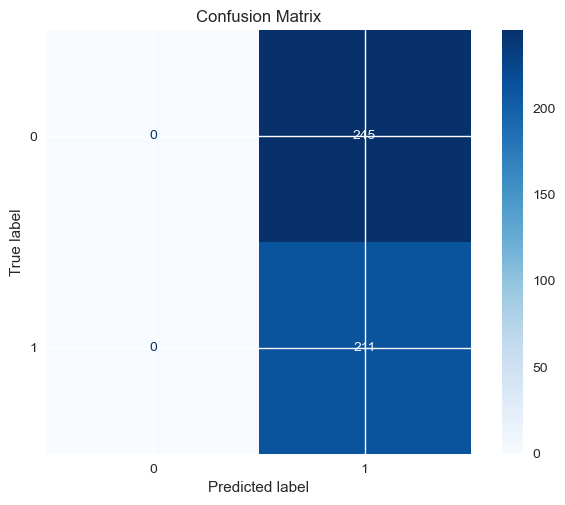

4/4 [==============================] - 0s 6ms/step


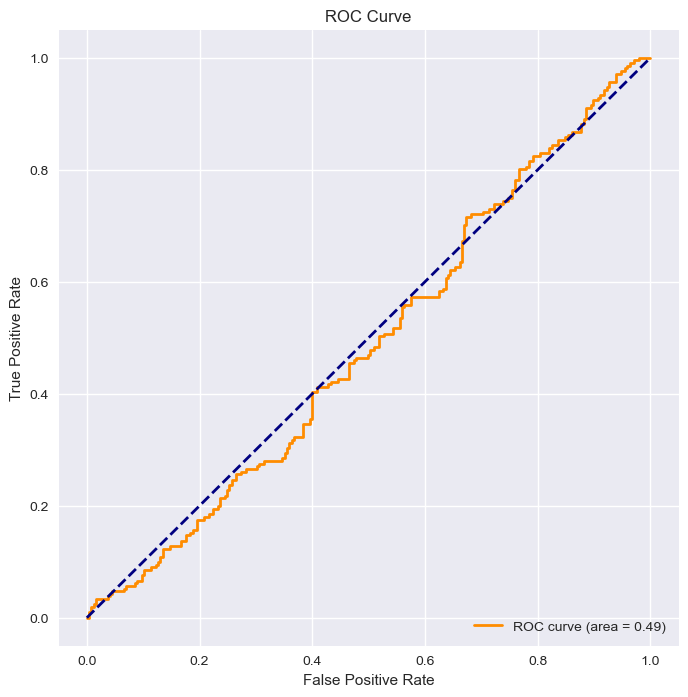

Model classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       245
           1       0.46      1.00      0.63       211

    accuracy                           0.46       456
   macro avg       0.23      0.50      0.32       456
weighted avg       0.21      0.46      0.29       456

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_start1 (Dense)        (None, None, 80)          7760      
                                                                 
 Dense_start2 (Dense)        (None, None, 44)          3564      
                                                                 
 Dense_start3 (Dense)        (None, None, 24)          1080      
                                                                 
 lstm1 (LSTM)                (None, None, 18)          3096      
                              

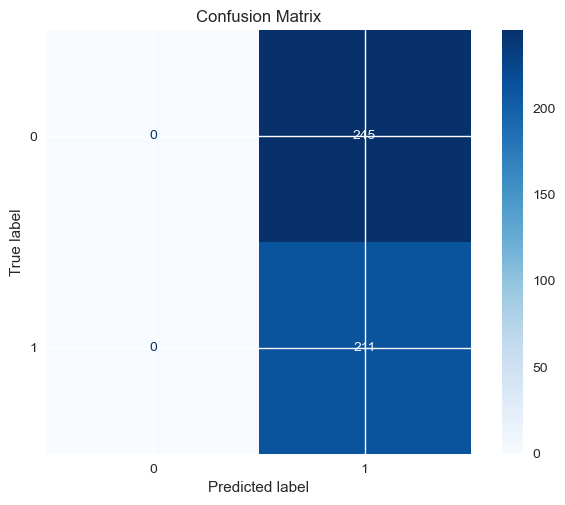

4/4 [==============================] - 0s 5ms/step


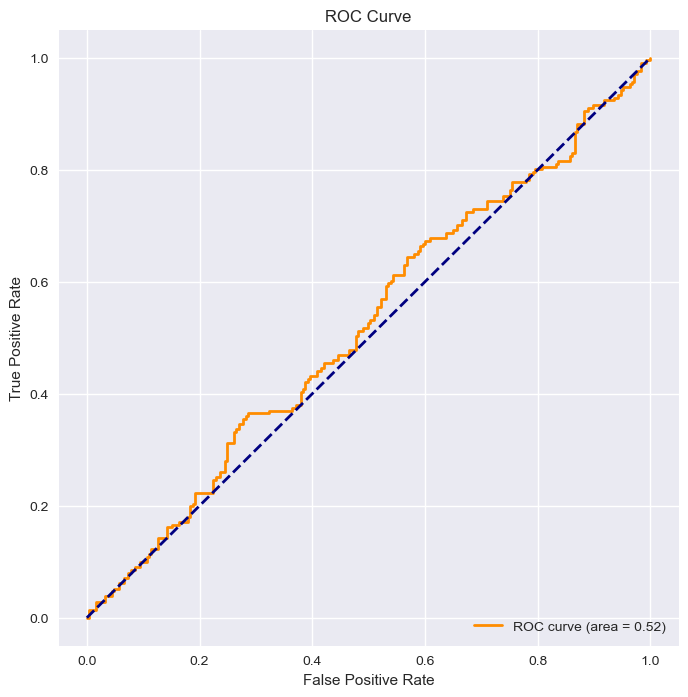

Model classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       245
           1       0.46      1.00      0.63       211

    accuracy                           0.46       456
   macro avg       0.23      0.50      0.32       456
weighted avg       0.21      0.46      0.29       456

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_start1 (Dense)        (None, None, 88)          8536      
                                                                 
 Dense_start2 (Dense)        (None, None, 20)          1780      
                                                                 
 LSTM1 (LSTM)                (None, 18)                2808      
                                                                 
 Dropout1 (Dropout)          (None, 18)                0         
                              

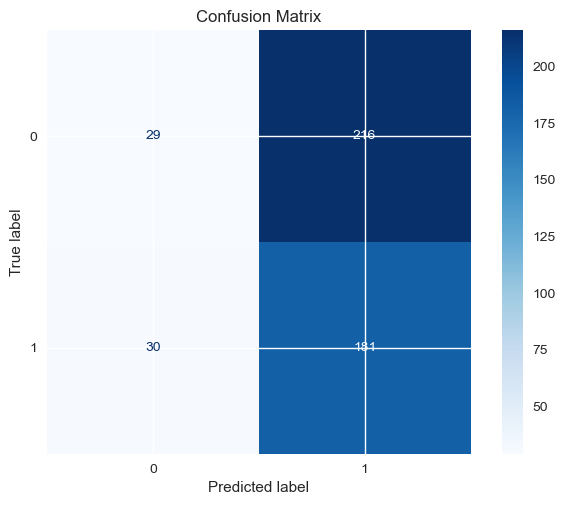

4/4 [==============================] - 0s 4ms/step


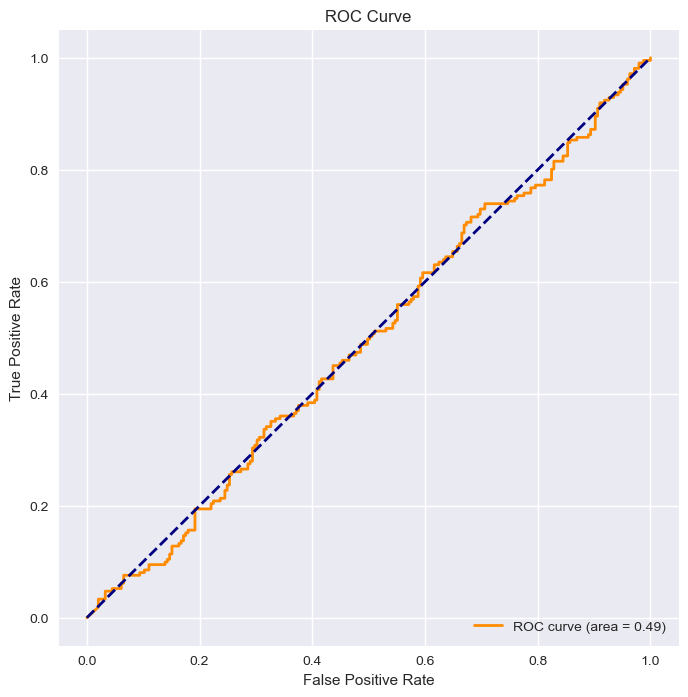

Model classification Report:
              precision    recall  f1-score   support

           0       0.49      0.12      0.19       245
           1       0.46      0.86      0.60       211

    accuracy                           0.46       456
   macro avg       0.47      0.49      0.39       456
weighted avg       0.48      0.46      0.38       456

HC set models:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_start1 (Dense)        (None, None, 115)         23000     
                                                                 
 Dense_start2 (Dense)        (None, None, 68)          7888      
                                                                 
 LSTM1 (LSTM)                (None, 22)                8008      
                                                                 
 Dropout1 (Dropout)          (None, 22)                0         
               

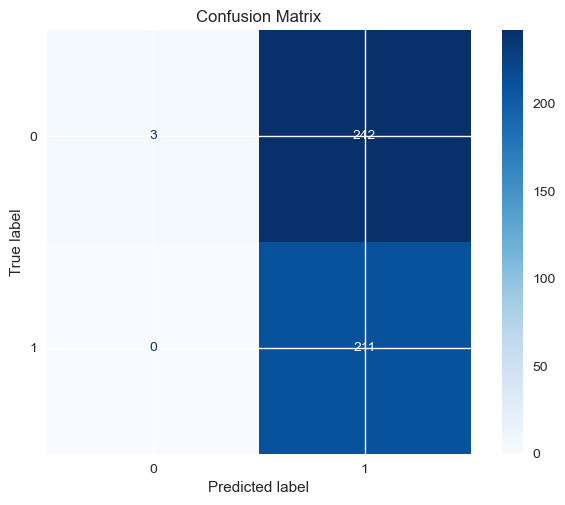

4/4 [==============================] - 0s 5ms/step


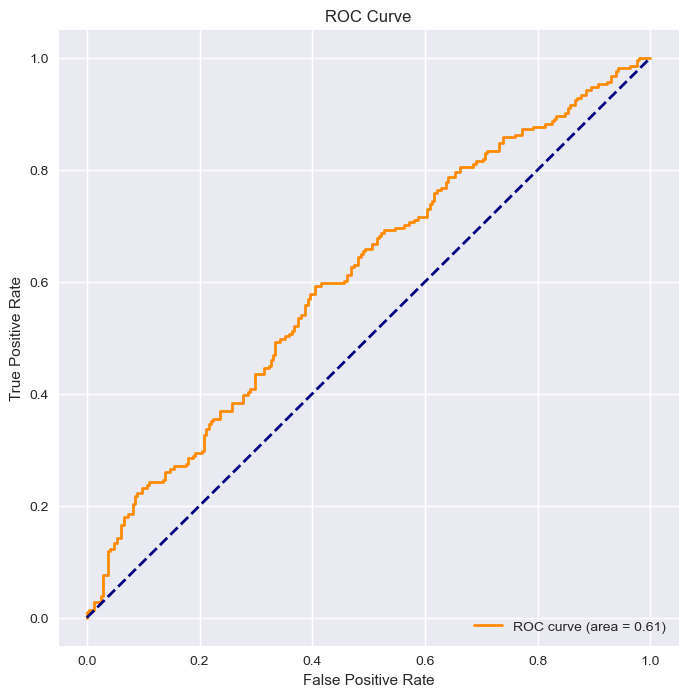

Model classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       245
           1       0.47      1.00      0.64       211

    accuracy                           0.47       456
   macro avg       0.73      0.51      0.33       456
weighted avg       0.75      0.47      0.31       456

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_start1 (Dense)        (None, None, 107)         21400     
                                                                 
 Dense_start2 (Dense)        (None, None, 84)          9072      
                                                                 
 LSTM1 (LSTM)                (None, 10)                3800      
                                                                 
 Dropout1 (Dropout)          (None, 10)                0         
                              

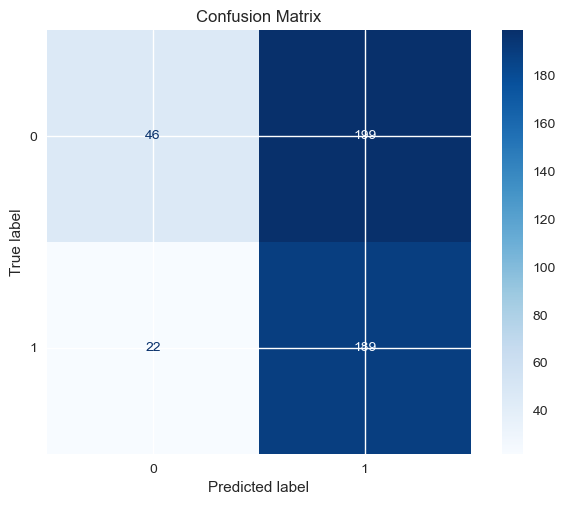

4/4 [==============================] - 0s 4ms/step


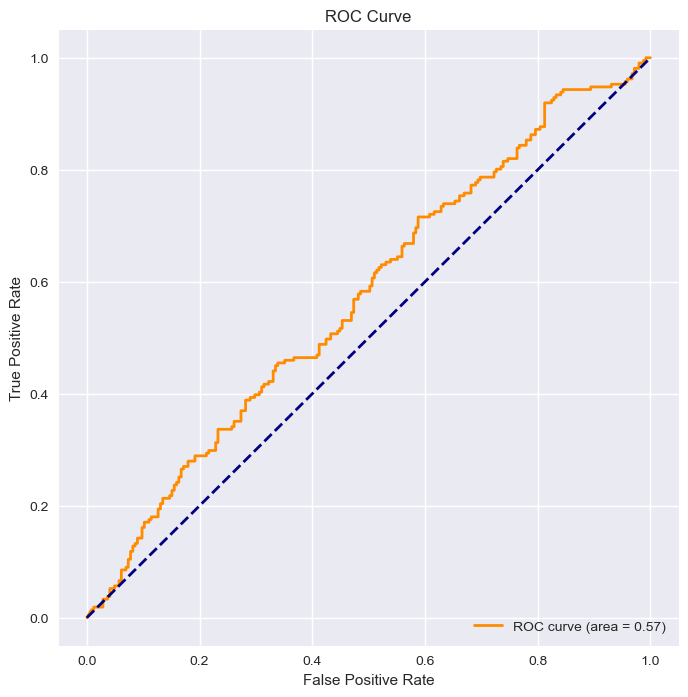

Model classification Report:
              precision    recall  f1-score   support

           0       0.68      0.19      0.29       245
           1       0.49      0.90      0.63       211

    accuracy                           0.52       456
   macro avg       0.58      0.54      0.46       456
weighted avg       0.59      0.52      0.45       456

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_start1 (Dense)        (None, None, 195)         39000     
                                                                 
 Dense_start2 (Dense)        (None, None, 81)          15876     
                                                                 
 Dense_start3 (Dense)        (None, None, 81)          6642      
                                                                 
 lstm1 (LSTM)                (None, None, 6)           2112      
                              

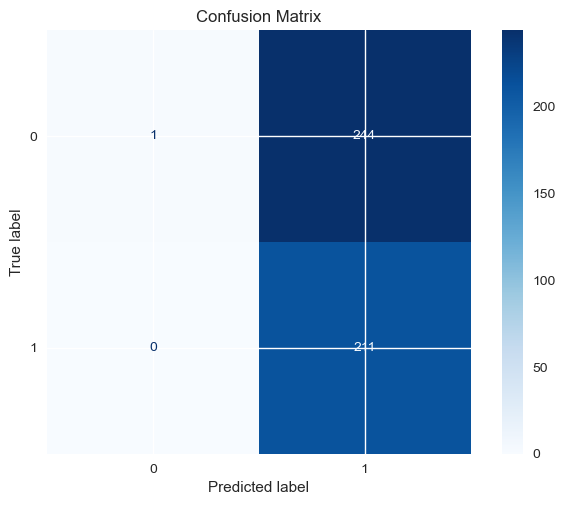

4/4 [==============================] - 0s 6ms/step


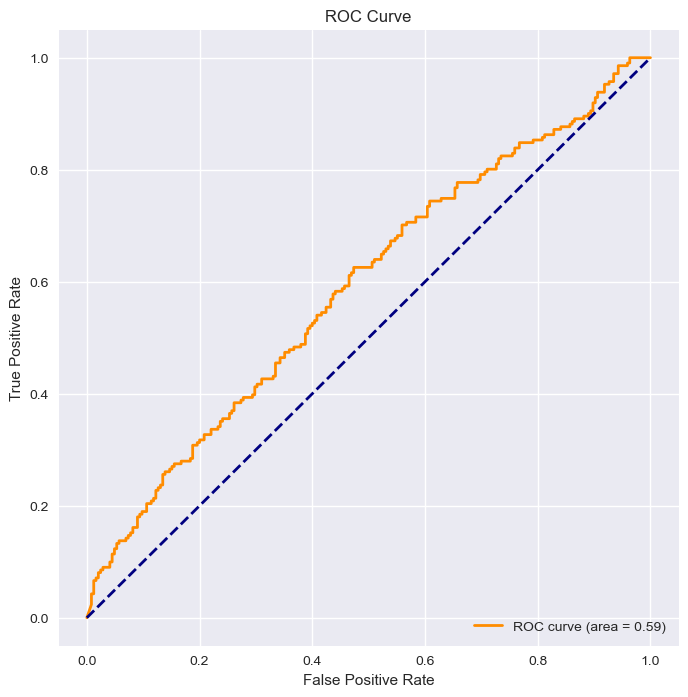

Model classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       245
           1       0.46      1.00      0.63       211

    accuracy                           0.46       456
   macro avg       0.73      0.50      0.32       456
weighted avg       0.75      0.46      0.30       456



[None, None, None]

In [64]:
# Call display model results function
print("XG set models:")
[display_model_results(model, g_dev_xg, y_dev) for model in best_xg_models]
print("KS set models:")
[display_model_results(model, g_dev_kmeans_som, y_dev) for model in best_ks_models]
print("HC set models:")
[display_model_results(model, g_dev_corr_filtered, y_dev) for model in best_hc_models]

### Get results for Baseline model

Now fitting model: LSTM_model_arch_1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 20)                9360      
                                                                 
 Dropout1 (Dropout)          (None, 20)                0         
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 9381 (36.64 KB)
Trainable params: 9381 (36.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
12/12 [==============================] - 1s 22ms/step - loss: 0.7428 - accuracy: 0.4858 - precision: 0.4512 - recall: 0.5736 - val_loss: 0.6962 - val_accuracy: 0.5285 - val_precision: 0.4895 - val_recall: 0.4408
Epoch 2/50
12/12 [========

INFO:tensorflow:Assets written to: ./models/baseline/baseline_baseline_ks_2024_01_11-02_36_22/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 20)                9360      
                                                                 
 Dropout1 (Dropout)          (None, 20)                0         
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 9381 (36.64 KB)
Trainable params: 9381 (36.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
4/4 [==============================] - 0s 4ms/step


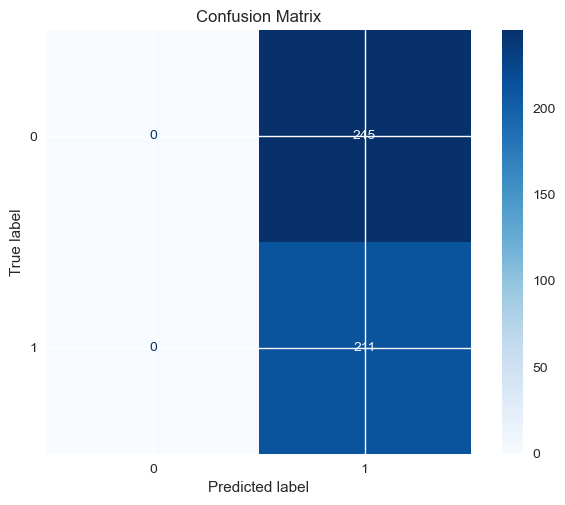

4/4 [==============================] - 0s 3ms/step


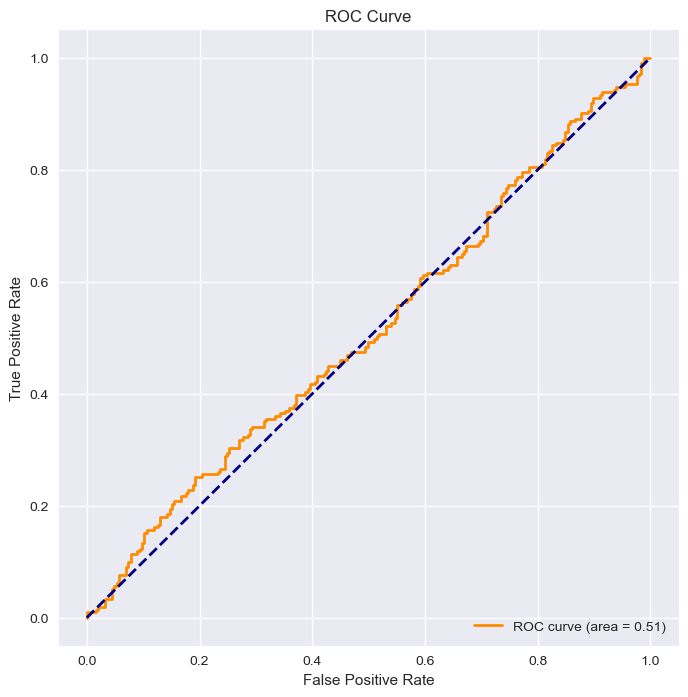

Model classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       245
           1       0.46      1.00      0.63       211

    accuracy                           0.46       456
   macro avg       0.23      0.50      0.32       456
weighted avg       0.21      0.46      0.29       456



In [71]:
def LSTM_model_arch_1(g_train, g_valid, features, lookback, class_weights, hu=128, data='ks'):
    '''
    Model architecture: 
    - 0 dense layers before LSTM layers
    - 1 LSTM layer, with drop-out
    - 0 dense layer before output
    
    '''
    
    tf.keras.backend.clear_session()   
    
    # instantiate the model
    model = Sequential()

    # tensorboard location
    datetime = dt.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    logdir = f"./tensorboard/LSTM/initial_run/{data}/{inspect.currentframe().f_code.co_name}_{datetime}"
    print(f"Now fitting model: {inspect.currentframe().f_code.co_name}")
    
    # first LSTM layer
    model.add(LSTM(units=hu*2, input_shape=(lookback, features), activation = 'elu', return_sequences=False, name='LSTM1'))

    # first dropout layer
    model.add(Dropout(0.4, name='Dropout1'))

    # output layer
    model.add(Dense(units=1, activation='sigmoid', name='Output'))

    # optimizer
    opt = Adam(learning_rate=LR, epsilon=1e-08)
    
    my_callbacks = [
        EarlyStopping(patience=PATIENCE, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True),TensorBoard(log_dir=logdir)
    ]

    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    # build model 
    model.build()
    
    # print model summary
    model.summary()

    # fit model
    history = model.fit(g_train,
              epochs=EPOCHS, 
              batch_size = BATCH,
              verbose=1, 
              callbacks=my_callbacks, 
              shuffle=False,
              class_weight=class_weights,
              validation_data=g_valid)

    # save model to directory
    model.save(f"./models/baseline/baseline_{data}_{datetime}")

    return model, history

# Make predictions using fitted baseline model 
baseline_model, baseline_model_history = LSTM_model_arch_1(g_train_kmeans_som, g_dev_kmeans_som, features=num_features_kmeans_som, lookback=seqlen, class_weights=class_weight, hu=10, data="baseline_ks")

# Display baseline model results
display_model_results(baseline_model, g_dev_kmeans_som, y_dev, threshold=0.001)

### Save final set of best models 

In [85]:
hc_best_14 = best_hc_models[1]

In [131]:
test_period_price = pd.read_csv("data/X_test_df_raw.csv")
test_period_price

,Date,Open,High,Low,Close,GBPUSD=X_Close,^FTSE_Close,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,ACCBL_20,ACCBM_20,ACCBU_20,AD,...,STD_21,UB_21,LB_21,LOGRET_LAG_63,CUM_LOGRET_63,PCHG_63,VCHG_63,MA_SCALED_63,VMA_SCALED_63,OC_63,HC_63,GAP_63,STD_63,UB_63,LB_63
0,2021-12-03,255.310756,256.546579,254.483223,256.409271,0.150556,-0.096791,254.993158,258.571603,251.414713,3.578445,247.497943,256.416113,265.455546,-1.756377e+09,...,0.008567,261.646853,250.770601,0.003878,0.092590,0.097011,0.142064,0.045404,-0.395575,3.394491e-04,0.015412,0.001184,0.011457,266.530436,224.015216
1,2021-12-06,257.233122,257.782380,255.173427,256.912720,-0.471244,1.544445,255.072497,258.586308,251.558685,3.513812,247.853382,256.681584,265.424904,-1.753301e+09,...,0.008562,261.539509,251.340013,-0.005433,0.099984,0.105153,-0.105762,0.045803,-0.511463,3.842643e-04,0.015425,0.001257,0.011423,266.860764,224.460912
2,2021-12-07,258.148542,260.528641,257.105871,260.253998,0.204273,1.487772,256.159463,259.680082,252.638844,3.520619,248.330278,256.947056,265.475902,-1.738057e+09,...,0.008923,261.702074,252.001325,-0.009186,0.122092,0.129858,-0.169103,0.057360,-0.035862,5.974301e-04,0.015477,0.001395,0.011426,267.280857,224.990396
3,2021-12-08,259.933599,262.267909,258.514680,258.835083,-0.137756,-0.034060,257.074877,260.611003,253.538750,3.536126,248.924231,256.846358,264.994925,-1.758380e+09,...,0.008637,261.878584,252.195339,-0.000982,0.117607,0.124802,1.350458,0.049651,0.286012,6.172225e-04,0.015232,0.001304,0.011459,267.570634,225.612330
4,2021-12-09,259.796290,260.891146,258.697802,259.063965,-0.272138,-0.219425,258.231113,261.677721,254.784505,3.446608,249.083688,256.814320,264.890278,-1.773047e+09,...,0.006990,261.570004,252.333914,0.007051,0.111440,0.117887,1.713538,0.048735,0.142179,5.102797e-04,0.015170,0.001313,0.011440,267.885977,226.164276
5,2021-12-10,258.789383,261.123694,258.606288,260.345581,0.105790,-0.402934,259.073546,262.458207,255.688885,3.384661,248.976779,256.786858,264.949060,-1.769688e+09,...,0.007015,261.684623,252.280327,-0.001562,0.117937,0.125174,-0.349880,0.051966,-0.541944,6.150321e-04,0.015153,0.001312,0.011439,268.220743,226.748971
6,2021-12-13,260.116694,262.039083,259.338581,261.215210,0.250561,-0.828326,259.921835,263.260886,256.582785,3.339050,249.010857,256.761683,264.925924,-1.763775e+09,...,0.006981,261.754954,252.240510,-0.004310,0.125582,0.133808,-0.466169,0.053397,-0.201293,7.441432e-04,0.015212,0.001304,0.011413,268.524301,227.424069
7,2021-12-14,261.810261,263.000296,259.953774,260.665985,-0.329011,-0.177003,260.303939,263.623487,256.984390,3.319548,249.401561,256.949346,264.750895,-1.773725e+09,...,0.006958,261.514251,252.380954,0.009573,0.113904,0.120644,0.124693,0.049297,-0.017687,5.847571e-04,0.015277,0.001278,0.011382,268.831651,228.007586
8,2021-12-15,261.535606,262.542546,258.331635,258.331635,0.128470,-0.662182,260.276481,263.655454,256.897509,3.378973,249.571503,257.148450,265.131603,-1.809552e+09,...,0.005938,261.621466,252.408873,-0.004677,0.109586,0.115816,0.303835,0.038122,0.870125,5.408015e-04,0.015272,0.001253,0.011435,268.940599,228.749858
9,2021-12-16,259.979388,260.162483,257.507741,258.514709,0.246555,1.252305,260.111949,263.442640,256.781259,3.330690,249.800036,257.288052,265.291482,-1.815128e+09,...,0.005450,261.694735,252.732284,-0.005878,0.116172,0.123189,0.681964,0.036982,0.196429,4.762898e-04,0.015202,0.001423,0.011394,268.955169,229.635392


### Backtesting: Model architecture 14 for HC set at various thresholds

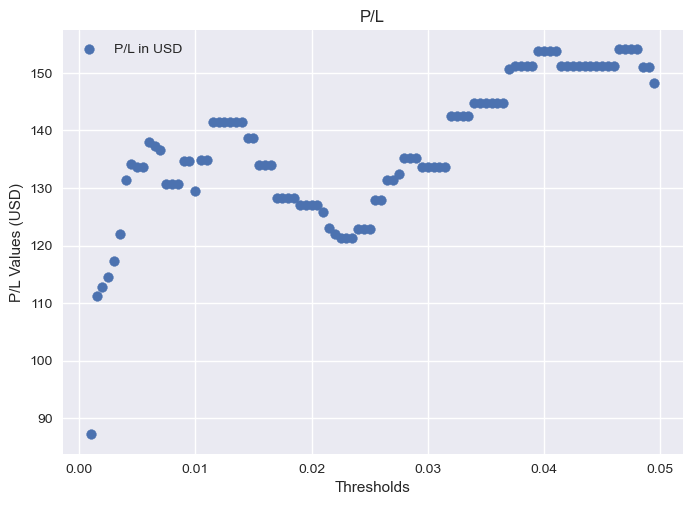

In [129]:
# Threshold
thresholds = np.arange(0.001, 0.05, 0.0005).tolist()
# Empty list for all P/Ls
all_PLs = []
all_sharpe = []
# Calculate P/L for all thresholds
for threshold in thresholds:
    # Generate predicted labels based on given threshold
    predicted_labels_test = np.where(hc_best_14.predict(g_test_corr_filtered, verbose=False) > threshold, 1, 0)
    # Get raw prices
    test_period_price = pd.read_csv("data/X_test_df_raw.csv")
    test_period_price['Date'] = pd.to_datetime(test_period_price['Date'])
    test_period_price.set_index('Date', inplace=True)
    test_period_price = test_period_price[['Close']]
    # Add predicted labels_test as a new column starting from the 22nd row
    test_period_price = test_period_price.iloc[21:, :] # only keep values from 
    test_period_price["Prediction"] = predicted_labels_test  # Set values starting from the 22nd row
    test_period_price['PL'] = test_period_price['Close'].diff().shift(-1)
    test_period_price = test_period_price.iloc[:-1]
    # Getting total P/L
    test_period_price['PL'] = test_period_price['Close'].diff()*test_period_price['Prediction']
    all_PLs.append(test_period_price['PL'].sum())
    all_sharpe.append(test_period_price['PL'].mean()/test_period_price['PL'].std())

# Create scatter plot of P/L movements at varying classification thresholds
plt.scatter(thresholds, all_PLs, label="P/L in USD")

# Labeling axes and title
plt.xlabel("Thresholds")
plt.ylabel("P/L Values (USD)")
plt.title("P/L")

# Display legend
plt.legend()

# Show the plot
plt.show()

In [132]:
all_PLs

[87.17390441894511,
 111.30323791503892,
 112.74516296386705,
 114.52578735351548,
 117.38607788085923,
 122.04244995117176,
 131.45185852050776,
 134.2571258544921,
 133.5841979980468,
 133.68606567382804,
 138.0225067138671,
 137.3496093749999,
 136.549591064453,
 130.64492797851554,
 130.64492797851554,
 130.64492797851554,
 134.71853637695304,
 134.71853637695304,
 129.5652618408202,
 134.87464904785145,
 134.87464904785145,
 141.38429260253895,
 141.38429260253895,
 141.38429260253895,
 141.38429260253895,
 141.38429260253895,
 141.47856140136705,
 138.7662200927733,
 138.7662200927733,
 133.9608306884764,
 133.9608306884764,
 133.9608306884764,
 128.32591247558577,
 128.32591247558577,
 128.32591247558577,
 128.32591247558577,
 127.04368591308577,
 127.04368591308577,
 127.04368591308577,
 127.04368591308577,
 125.83360290527327,
 123.04588317871074,
 122.0595703124998,
 121.38665771484355,
 121.38665771484355,
 121.38665771484355,
 122.96125793457014,
 122.96125793457014,
 122.9

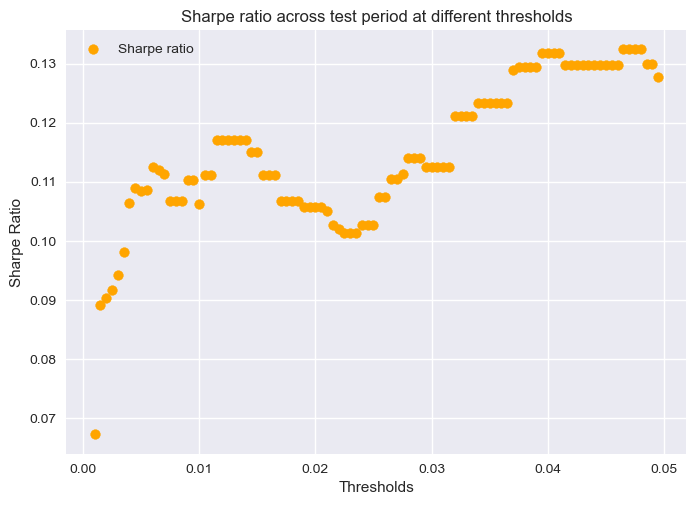

In [126]:
# Create scatter plot of Sharpe ratio at varying classification thresholds
plt.scatter(thresholds, all_sharpe, label="Sharpe ratio", color='orange')

# Labeling axes and title
plt.xlabel("Thresholds")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe ratio across test period at different thresholds")

# Display legend
plt.legend()

# Show the plot
plt.show()